In [2]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 20.8 MB/s eta 0:00:0000:0100:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=93dc985b53984915734a75637ca269da51b92b4a81dd5861c337db81704be9df
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77058 sha256=7a8c142114339df286d9194e4349f9ba06b70624def35ec71be37769628d17b3
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built bs4 wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.0
    Uninstalling wrapt-1.14.0:
  

# Test your models

## data split

In [91]:
x_all_pre, y_all_pre = wine_data_loader.get_data3()
x_all_augmented, y_all_augmented = (x_all_pre, y_all_pre)
x, y, x_test, y_test = wine_data_loader.split(x_all_augmented, y_all_augmented)

In [67]:
# x_all_pre, y_all_pre = wine_data_loader.get_data3()
# x_all_augmented, y_all_augmented = (x_all_pre, y_all_pre)
# x, y  = x_all_augmented, y_all_augmented

## model builder

In [186]:
import numpy as np
import pandas as pd
from keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from tool import wine_data_loader, tflite_converter
import cfg
import tensorflow as tf
from keras import metrics

def build_model(act,kernel_count,drop_out_rate,loop_count,pool_size,strides,kernel_size,lr):
    print('params','act',act,'kernel_count',kernel_count,'drop_out_rate',drop_out_rate,'loop_count',loop_count,'pool_size',pool_size,'strides',strides,'kernel_size',kernel_size,'lr',lr)
    # pool_size = 1
    # strides = (1,)
    # act = 'tanh'
    # kernel_count = 12
    # drop_out_rate = .2

    inp = __next = layers.Input(shape=[1000], name='input')
    __next = layers.BatchNormalization()(__next)

    __next = layers.Reshape(target_shape=[1000,1])(__next)

    for i in range(loop_count):
        __next = layers.MaxPool1D(pool_size=pool_size, strides=pool_size, )(__next)
        __next = layers.Conv1D(filters=kernel_count, kernel_size=kernel_size, activation=act, )(__next)

    # __next = layers.Dense(800, activation=act)(__next)
    __next = layers.Reshape(target_shape=[-1])(__next)

    # __next = layers.Dense(100, activation=act)(__next)
    
    __next = layers.Dense(cfg.classify_count, activation=act)(__next)
    __next = layers.Dense(cfg.classify_count, activation=act)(__next)
    output = __next = layers.Dense(cfg.classify_count, activation='softmax')(__next)
    model = keras.Model(inputs=[inp], outputs=[output])

    opt = tf.keras.optimizers.Adam(lr=lr)

    # model.summary()
    # ,metrics= [metrics.categorical_accuracy]
    model.compile(
        optimizer=opt,
        # optimizer='adam',
        loss='categorical_crossentropy',
        # loss='mse',
        # metric s=['val_mse']
        metrics=['categorical_accuracy']
    )
    return model


import random
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


In [89]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model) 

# act,kernel_count,drop_out_rate,loop_count,pool_size,strides,kernel_size
# param_distribs = {
#     'act' : ['relu','tanh','sigmoid'],
#     'kernel_count' : np.random.randint(low=1, high=20, size=10),
#     'drop_out_rate' : np.random.uniform(low=0.0, high=0.5, size=10),
#     'loop_count' : np.random.randint(low=1, high=10, size=10),
#     'pool_size' : [*np.random.randint(low=1, high=10, size=10),*np.random.randint(low=10, high=100, size=10),*np.random.randint(low=100, high=1000, size=10)],
#     'strides' : [*np.random.randint(low=1, high=10, size=10),*np.random.randint(low=10, high=100, size=10),*np.random.randint(low=100, high=1000, size=10)],
#     'kernel_size' : [*np.random.randint(low=1, high=20, size=10),*np.random.randint(low=20, high=100, size=10)],
#     'lr': reciprocal(1e-10, 1e-2),
# }

param_distribs = {
    'act' : ['relu','tanh','sigmoid'],
    'kernel_count' : [i for i in range(20)],
    'drop_out_rate' : [0.1,0.2,0.3],
    'loop_count' : [i for i in range(5)],
    'pool_size' : [*[i for i in range(10)],*[i for i in range(100,1000,100)]],
    'strides' : range(10),
    'kernel_size' : [1,3,7,15,30,60,100],
    'lr': [1e-2,1e-3,1e-4,1e-5],
}
# param_distribs

In [90]:

rnd_search_cv = GridSearchCV(keras_reg, param_distribs)
# rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=2)

rnd_search_cv.fit(x, y, epochs=20,
                #   validation_data=(x_test, y_test),
                  callbacks=[keras.callbacks.EarlyStopping(patience=50)]) 


params act relu kernel_count 0 drop_out_rate 0.1 loop_count 0 pool_size 0 strides 0 kernel_size 1 lr 0.01
Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 3ms/step - loss: 241572.8125 - categorical_accuracy: 0.1639
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 79750.3281 - categorical_accuracy: 0.3750
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 11737.7139 - categorical_accuracy: 0.7230
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 2619.5728 - categorical_accuracy: 0.8767
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2377.7634 - categorical_accuracy: 0.8818
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2299.5674 - categorical_accuracy: 0.8649
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 645.2797 - categorical_accuracy: 0.9375
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 508.0970 - categorical_accuracy: 0.9341
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 2167.5371 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 156912.8438 - categorical_accuracy: 0.1402
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 106257.6406 - categorical_accuracy: 0.2720
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 20130.7617 - categorical_accuracy: 0.5794
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5673.3101 - categorical_accuracy: 0.7331
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2114.7107 - categorical_accuracy: 0.8463
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 330.8411 - categorical_accuracy: 0.9274
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 356.1681 - categorical_accuracy: 0.9375
Epoch 8/20
19/19 [==============================] - 0s 8ms/step - loss: 483.6747 - categorical_accuracy: 0.9628
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 123.7246 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 261463.1562 - categorical_accuracy: 0.1166
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 128390.5703 - categorical_accuracy: 0.3328
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 27775.8633 - categorical_accuracy: 0.6047
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7434.5298 - categorical_accuracy: 0.7365
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 4297.1206 - categorical_accuracy: 0.8007
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3888.1511 - categorical_accuracy: 0.8733
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 9833.0518 - categorical_accuracy: 0.8463
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 6627.3682 - categorical_accuracy: 0.8784
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 977.8198 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 254437.7344 - categorical_accuracy: 0.1419
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 108060.4219 - categorical_accuracy: 0.3851
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 36727.8086 - categorical_accuracy: 0.5422
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 17192.2441 - categorical_accuracy: 0.7128
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 4069.2056 - categorical_accuracy: 0.8818
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 4017.6631 - categorical_accuracy: 0.8818
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 707.6097 - categorical_accuracy: 0.9189
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 103.4520 - categorical_accuracy: 0.9713
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 93.5140 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 316779.4062 - categorical_accuracy: 0.1622
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 90716.2812 - categorical_accuracy: 0.4223
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 15581.0713 - categorical_accuracy: 0.5895
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 3577.8721 - categorical_accuracy: 0.8277
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1062.1938 - categorical_accuracy: 0.9223
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1265.1381 - categorical_accuracy: 0.9307
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 264.5670 - categorical_accuracy: 0.9696
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 494.9249 - categorical_accuracy: 0.9814
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 256.4199 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 273082.6875 - categorical_accuracy: 0.1216
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 109174.4609 - categorical_accuracy: 0.3885
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 21797.3770 - categorical_accuracy: 0.6182
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5990.3076 - categorical_accuracy: 0.7517
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 3383.5718 - categorical_accuracy: 0.8361
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2079.5166 - categorical_accuracy: 0.8547
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 524.8538 - categorical_accuracy: 0.9493
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 211.0000 - categorical_accuracy: 0.9679
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 946.8510 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 222830.3438 - categorical_accuracy: 0.1149
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 161608.0000 - categorical_accuracy: 0.3311
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 33612.4609 - categorical_accuracy: 0.5507
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9156.8135 - categorical_accuracy: 0.7196
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2138.8906 - categorical_accuracy: 0.8412
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2649.9392 - categorical_accuracy: 0.8986
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 2100.0710 - categorical_accuracy: 0.9054
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 3339.1091 - categorical_accuracy: 0.8986
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 14758.7285 - categorical_accur

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 177871.0469 - categorical_accuracy: 0.1689
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 52925.5312 - categorical_accuracy: 0.5101
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 20061.3652 - categorical_accuracy: 0.6385
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9791.8652 - categorical_accuracy: 0.7703
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 4478.0674 - categorical_accuracy: 0.8598
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1686.1854 - categorical_accuracy: 0.9206
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 438.7233 - categorical_accuracy: 0.9459
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 143.8975 - categorical_accuracy: 0.9662
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 96.1893 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 247266.2656 - categorical_accuracy: 0.1520
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 105949.3516 - categorical_accuracy: 0.4544
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 32787.6133 - categorical_accuracy: 0.5811
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4533.4087 - categorical_accuracy: 0.7956
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1000.5851 - categorical_accuracy: 0.8682
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 705.2315 - categorical_accuracy: 0.9274
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1756.1902 - categorical_accuracy: 0.9189
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 149.9289 - categorical_accuracy: 0.9662
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 132.5388 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 220716.9219 - categorical_accuracy: 0.1605
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 78824.3359 - categorical_accuracy: 0.4257
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 11944.4521 - categorical_accuracy: 0.7145
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7280.3716 - categorical_accuracy: 0.7990
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 8834.3086 - categorical_accuracy: 0.7838
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 4266.3716 - categorical_accuracy: 0.8699
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 972.2517 - categorical_accuracy: 0.8986
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 635.0816 - categorical_accuracy: 0.9459
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 212.8213 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 204904.7031 - categorical_accuracy: 0.1791
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 107774.3672 - categorical_accuracy: 0.4561
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 29763.0000 - categorical_accuracy: 0.6436
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 16810.0156 - categorical_accuracy: 0.8125
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 10638.4092 - categorical_accuracy: 0.9071
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 8416.5508 - categorical_accuracy: 0.8834
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 6210.8721 - categorical_accuracy: 0.9020
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 3284.9353 - categorical_accuracy: 0.8936
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1075.5020 - categorical_accu

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 166892.9688 - categorical_accuracy: 0.2095
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 84651.7344 - categorical_accuracy: 0.3801
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 25427.7930 - categorical_accuracy: 0.6622
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5188.3774 - categorical_accuracy: 0.8395
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1311.6987 - categorical_accuracy: 0.9088
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3472.4810 - categorical_accuracy: 0.9054
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1567.7761 - categorical_accuracy: 0.8750
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 963.5791 - categorical_accuracy: 0.9189
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 352.9386 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 5ms/step - loss: 193352.8906 - categorical_accuracy: 0.2162
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 61480.3906 - categorical_accuracy: 0.4105
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 19116.3184 - categorical_accuracy: 0.6824
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 5327.4878 - categorical_accuracy: 0.7973
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5609.2251 - categorical_accuracy: 0.8767
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 304.7784 - categorical_accuracy: 0.9780
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 21.9214 - categorical_accuracy: 0.9882
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 290632.2500 - categorical_accuracy: 0.1503
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 152109.6094 - categorical_accuracy: 0.4628
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 44570.5312 - categorical_accuracy: 0.6267
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 12721.0811 - categorical_accuracy: 0.7551
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5169.9917 - categorical_accuracy: 0.8784
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 733.5927 - categorical_accuracy: 0.9054
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 243.7121 - categorical_accuracy: 0.9493
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 99.6162 - categorical_accuracy: 0.9662
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1061.8159 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 146379.8750 - categorical_accuracy: 0.2399
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 55021.6367 - categorical_accuracy: 0.4544
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 15346.5654 - categorical_accuracy: 0.6655
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4021.2170 - categorical_accuracy: 0.8125
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 3022.5420 - categorical_accuracy: 0.8395
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1451.7272 - categorical_accuracy: 0.9189
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 962.1862 - categorical_accuracy: 0.9645
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1121.1143 - categorical_accuracy: 0.9459
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 3147.3579 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 351433.3438 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 114574.1094 - categorical_accuracy: 0.3885
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 37296.2969 - categorical_accuracy: 0.5980
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 6117.1562 - categorical_accuracy: 0.8209
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 3159.3267 - categorical_accuracy: 0.8446
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2194.5830 - categorical_accuracy: 0.8834
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1256.0598 - categorical_accuracy: 0.9274
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 783.1674 - categorical_accuracy: 0.9544
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 648.0181 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 151840.9062 - categorical_accuracy: 0.1436
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 67907.8438 - categorical_accuracy: 0.4341
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 22748.6055 - categorical_accuracy: 0.6098
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 11175.1318 - categorical_accuracy: 0.7720
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 9679.5215 - categorical_accuracy: 0.8902
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2842.8523 - categorical_accuracy: 0.8970
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 272.7619 - categorical_accuracy: 0.9375
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 165.9398 - categorical_accuracy: 0.9544
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 766.7781 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 378720.4375 - categorical_accuracy: 0.1368
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 133664.1562 - categorical_accuracy: 0.2939
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 30374.8555 - categorical_accuracy: 0.5574
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 12932.0498 - categorical_accuracy: 0.7432
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1723.3580 - categorical_accuracy: 0.8851
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 29.9633 - categorical_accuracy: 0.9831
Epoch 7/20
19/19 [==============================] - 0s 7ms/step - loss: 24.1087 - categorical_accuracy: 0.9932
Epoch 8/20
19/19 [==============================] - 0s 6ms/step - loss: 65.7342 - categorical_accuracy: 0.9916
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 44.9548 - categorical_accuracy: 0.9

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 238180.1875 - categorical_accuracy: 0.1639
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 106168.7344 - categorical_accuracy: 0.3514
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 29925.9629 - categorical_accuracy: 0.5743
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4645.8374 - categorical_accuracy: 0.8074
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1033.4607 - categorical_accuracy: 0.8970
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 324.9011 - categorical_accuracy: 0.9459
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 146.1066 - categorical_accuracy: 0.9628
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 97.5275 - categorical_accuracy: 0.9730
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 67.3184 - categorical_accuracy: 0.

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 248928.3438 - categorical_accuracy: 0.1368
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 90247.1875 - categorical_accuracy: 0.4392
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 11268.3105 - categorical_accuracy: 0.7297
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 3265.6609 - categorical_accuracy: 0.8108
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 4587.3486 - categorical_accuracy: 0.8041
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2362.7102 - categorical_accuracy: 0.9037
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 6329.0269 - categorical_accuracy: 0.8395
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1327.8486 - categorical_accuracy: 0.9324
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1042.6793 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 289125.7500 - categorical_accuracy: 0.2128
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 74509.3203 - categorical_accuracy: 0.4764
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 14562.0645 - categorical_accuracy: 0.6250
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7507.7778 - categorical_accuracy: 0.7078
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2385.4495 - categorical_accuracy: 0.8919
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3035.7642 - categorical_accuracy: 0.9020
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 3061.2134 - categorical_accuracy: 0.8834
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1324.9580 - categorical_accuracy: 0.9392
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 882.0370 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 233292.6719 - categorical_accuracy: 0.1351
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 123638.5938 - categorical_accuracy: 0.2568
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 24073.8242 - categorical_accuracy: 0.5051
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4649.6123 - categorical_accuracy: 0.8057
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1142.5842 - categorical_accuracy: 0.8902
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 78.7784 - categorical_accuracy: 0.9493
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 698.7169 - categorical_accuracy: 0.9223
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 6979.2334 - categorical_accuracy: 0.8936
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1833.7356 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 133708.9375 - categorical_accuracy: 0.2078
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 49808.2344 - categorical_accuracy: 0.4966
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 19181.3887 - categorical_accuracy: 0.6622
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 751.5949 - categorical_accuracy: 0.9037
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 107.6830 - categorical_accuracy: 0.9493
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 25.2605 - categorical_accuracy: 0.9865
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 60.4408 - categorical_accuracy: 0.9730
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 128.9891 - categorical_accuracy: 0.9730
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 216790.7500 - categorical_accuracy: 0.2061
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 64906.0195 - categorical_accuracy: 0.5372
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 7341.5972 - categorical_accuracy: 0.7162
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 653.4132 - categorical_accuracy: 0.9172
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 459.0468 - categorical_accuracy: 0.9426
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 386.2083 - categorical_accuracy: 0.9561
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 191.8210 - categorical_accuracy: 0.9392
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 58.3693 - categorical_accuracy: 0.9730
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 72.8157 - categorical_accuracy: 0.9713

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 208687.8281 - categorical_accuracy: 0.2280
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 103438.2500 - categorical_accuracy: 0.5253
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 33326.0273 - categorical_accuracy: 0.6993
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 14011.8467 - categorical_accuracy: 0.7348
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 7416.1172 - categorical_accuracy: 0.9155
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 4463.8262 - categorical_accuracy: 0.9155
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1305.4065 - categorical_accuracy: 0.9341
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 260.8511 - categorical_accuracy: 0.9730
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 106.6002 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 358754.3125 - categorical_accuracy: 0.1318
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 65405.6875 - categorical_accuracy: 0.3784
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 18753.5312 - categorical_accuracy: 0.5625
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4273.4834 - categorical_accuracy: 0.8125
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2787.8508 - categorical_accuracy: 0.8699
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 6835.4800 - categorical_accuracy: 0.8682
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 2513.2585 - categorical_accuracy: 0.9375
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1134.0968 - categorical_accuracy: 0.9662
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 840.9709 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 134084.2500 - categorical_accuracy: 0.2044
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 55521.8477 - categorical_accuracy: 0.4105
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 12203.6748 - categorical_accuracy: 0.6824
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 2582.5435 - categorical_accuracy: 0.8361
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 894.0722 - categorical_accuracy: 0.9155
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1343.4902 - categorical_accuracy: 0.9020
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 898.2656 - categorical_accuracy: 0.9037
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 231.9524 - categorical_accuracy: 0.9476
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 56.8316 - categorical_accuracy: 0.

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 4ms/step - loss: 224517.9375 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 103825.2188 - categorical_accuracy: 0.3581
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 20671.1113 - categorical_accuracy: 0.5997
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 3660.9768 - categorical_accuracy: 0.7956
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1344.8782 - categorical_accuracy: 0.8801
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 500.4452 - categorical_accuracy: 0.9375
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 72.2050 - categorical_accuracy: 0.9764
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 0.2579 - categorical_accuracy: 0.9983
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 5.1502 - categorical_accuracy: 0.993

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 329505.3125 - categorical_accuracy: 0.1318
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 120887.5547 - categorical_accuracy: 0.3885
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 33451.5469 - categorical_accuracy: 0.5389
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 8734.8652 - categorical_accuracy: 0.7382
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5575.2798 - categorical_accuracy: 0.7078
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 526.1143 - categorical_accuracy: 0.9105
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 105.7380 - categorical_accuracy: 0.9696
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 231.1581 - categorical_accuracy: 0.9544
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 201.2398 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 342605.5312 - categorical_accuracy: 0.1537
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 142326.2188 - categorical_accuracy: 0.3243
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 49319.0703 - categorical_accuracy: 0.4645
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7409.3843 - categorical_accuracy: 0.7551
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2528.8923 - categorical_accuracy: 0.8041
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 703.8954 - categorical_accuracy: 0.8953
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 3474.2695 - categorical_accuracy: 0.9020
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 3086.2754 - categorical_accuracy: 0.8784
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1565.9656 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 259572.2969 - categorical_accuracy: 0.1655
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 122899.2734 - categorical_accuracy: 0.3649
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 32881.0625 - categorical_accuracy: 0.5929
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 12551.9092 - categorical_accuracy: 0.6892
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2147.0737 - categorical_accuracy: 0.9088
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1601.3201 - categorical_accuracy: 0.9054
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1067.4762 - categorical_accuracy: 0.9206
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 817.8077 - categorical_accuracy: 0.9223
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 570.1421 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 209862.3438 - categorical_accuracy: 0.0912
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 94814.0703 - categorical_accuracy: 0.3159
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 30110.0703 - categorical_accuracy: 0.5912
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 10675.8779 - categorical_accuracy: 0.7753
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2777.6577 - categorical_accuracy: 0.8716
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 975.6005 - categorical_accuracy: 0.8784
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 249.2491 - categorical_accuracy: 0.9493
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 780.8125 - categorical_accuracy: 0.8986
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 904.7894 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 258468.1406 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 107361.6641 - categorical_accuracy: 0.3547
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 24153.5859 - categorical_accuracy: 0.6098
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 1344.3115 - categorical_accuracy: 0.8632
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 983.9891 - categorical_accuracy: 0.9240
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 221.8358 - categorical_accuracy: 0.9510
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 61.2945 - categorical_accuracy: 0.9764
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 11.0873 - categorical_accuracy: 0.9932
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 3.3559 - categorical_accuracy: 0.993

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 234811.1406 - categorical_accuracy: 0.1639
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 70320.7734 - categorical_accuracy: 0.4713
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 26324.5684 - categorical_accuracy: 0.7416
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 11052.5605 - categorical_accuracy: 0.8328
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5190.9131 - categorical_accuracy: 0.8159
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1100.2848 - categorical_accuracy: 0.9105
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 9707.6025 - categorical_accuracy: 0.8294
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 815.4373 - categorical_accuracy: 0.9358
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 203.3594 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 211168.6875 - categorical_accuracy: 0.2095
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 79931.8438 - categorical_accuracy: 0.4932
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 19453.0059 - categorical_accuracy: 0.6791
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 3537.2976 - categorical_accuracy: 0.8311
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1432.0796 - categorical_accuracy: 0.9223
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 705.4706 - categorical_accuracy: 0.9831
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 610.6213 - categorical_accuracy: 0.9882
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 539.7460 - categorical_accuracy: 0.9899
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 556.3942 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 299483.8125 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 92214.4922 - categorical_accuracy: 0.3750
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 27791.6816 - categorical_accuracy: 0.5659
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 10778.2295 - categorical_accuracy: 0.7297
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 3634.0950 - categorical_accuracy: 0.8108
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 561.5869 - categorical_accuracy: 0.9139
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 214.8573 - categorical_accuracy: 0.9561
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 264.0666 - categorical_accuracy: 0.9578
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 63.3364 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 284277.5938 - categorical_accuracy: 0.1064
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 134703.8281 - categorical_accuracy: 0.2500
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 25273.2461 - categorical_accuracy: 0.4949
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9123.1250 - categorical_accuracy: 0.7821
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1399.6230 - categorical_accuracy: 0.8716
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 219.0667 - categorical_accuracy: 0.9510
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 100.2576 - categorical_accuracy: 0.9578
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 67.5973 - categorical_accuracy: 0.9679
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1008.8358 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 120480.4062 - categorical_accuracy: 0.2128
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 58758.5625 - categorical_accuracy: 0.4274
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 10655.1406 - categorical_accuracy: 0.7551
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 3159.7539 - categorical_accuracy: 0.8226
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 7889.2339 - categorical_accuracy: 0.8530
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1482.9320 - categorical_accuracy: 0.9324
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 9998.4492 - categorical_accuracy: 0.8970
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 13768.7393 - categorical_accuracy: 0.8395
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 8000.6816 - categorical_accura

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 210630.0156 - categorical_accuracy: 0.1250
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 134496.3438 - categorical_accuracy: 0.3463
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 44670.7461 - categorical_accuracy: 0.6166
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9744.8877 - categorical_accuracy: 0.7618
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1754.8761 - categorical_accuracy: 0.8547
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1012.7728 - categorical_accuracy: 0.8834
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 372.0121 - categorical_accuracy: 0.9223
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 178.5486 - categorical_accuracy: 0.9459
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 521.6961 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 210634.9531 - categorical_accuracy: 0.1757
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 100164.8047 - categorical_accuracy: 0.4274
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 35721.6602 - categorical_accuracy: 0.6030
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 12212.1475 - categorical_accuracy: 0.7990
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 9296.5488 - categorical_accuracy: 0.8530
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 8289.7979 - categorical_accuracy: 0.8260
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 10515.3867 - categorical_accuracy: 0.8361
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1327.2469 - categorical_accuracy: 0.8986
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 492.2203 - categorical_accur

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 272947.4688 - categorical_accuracy: 0.1301
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 81518.7266 - categorical_accuracy: 0.4662
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 17098.6035 - categorical_accuracy: 0.7365
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 6102.0361 - categorical_accuracy: 0.8294
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 3532.3137 - categorical_accuracy: 0.9189
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3060.4485 - categorical_accuracy: 0.9578
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 2913.5481 - categorical_accuracy: 0.9713
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 2763.0540 - categorical_accuracy: 0.9611
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 2784.5852 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 4ms/step - loss: 155953.1719 - categorical_accuracy: 0.1486
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 106402.6250 - categorical_accuracy: 0.3074
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 25194.1855 - categorical_accuracy: 0.5574
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 4802.6099 - categorical_accuracy: 0.7618
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 1088.3549 - categorical_accuracy: 0.8868
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 644.6364 - categorical_accuracy: 0.9071
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 1017.2233 - categorical_accuracy: 0.8953
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 851.2385 - categorical_accuracy: 0.8885
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 2134.2729 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 189236.3438 - categorical_accuracy: 0.1892
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 48746.6641 - categorical_accuracy: 0.5355
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 13679.7285 - categorical_accuracy: 0.6807
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 3557.3132 - categorical_accuracy: 0.8733
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 276.6401 - categorical_accuracy: 0.9341
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 237.8076 - categorical_accuracy: 0.9595
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1135.4077 - categorical_accuracy: 0.9527
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 771.9689 - categorical_accuracy: 0.9155
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 707.1333 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 210599.7500 - categorical_accuracy: 0.1993
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 52287.2578 - categorical_accuracy: 0.4561
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 10162.0420 - categorical_accuracy: 0.6892
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 2084.4602 - categorical_accuracy: 0.8480
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 821.2918 - categorical_accuracy: 0.9071
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2266.1409 - categorical_accuracy: 0.8986
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1036.4703 - categorical_accuracy: 0.9122
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 328.8887 - categorical_accuracy: 0.9358
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 474.1053 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 291094.3125 - categorical_accuracy: 0.1520
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 71347.5859 - categorical_accuracy: 0.3936
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 13798.1064 - categorical_accuracy: 0.6723
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 1757.1691 - categorical_accuracy: 0.8209
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 457.5228 - categorical_accuracy: 0.9274
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 385.0330 - categorical_accuracy: 0.9527
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 627.7450 - categorical_accuracy: 0.9814
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 385.7171 - categorical_accuracy: 0.9932
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 73.3118 - categorical_accuracy: 0.9

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 4ms/step - loss: 295965.4375 - categorical_accuracy: 0.1402
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 130129.2188 - categorical_accuracy: 0.3547
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 43718.1367 - categorical_accuracy: 0.5625
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9163.4990 - categorical_accuracy: 0.7230
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5154.8096 - categorical_accuracy: 0.8311
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2069.9187 - categorical_accuracy: 0.8936
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 600.5736 - categorical_accuracy: 0.9122
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 2845.9978 - categorical_accuracy: 0.9240
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 2362.3794 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 223060.0312 - categorical_accuracy: 0.1284
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 115351.9453 - categorical_accuracy: 0.2753
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 29482.0312 - categorical_accuracy: 0.5524
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 20513.6543 - categorical_accuracy: 0.6892
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 9502.6084 - categorical_accuracy: 0.8057
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 6695.2422 - categorical_accuracy: 0.8311
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 1248.0663 - categorical_accuracy: 0.8936
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 543.7856 - categorical_accuracy: 0.9189
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 1351.7014 - categorical_accura

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 204104.2188 - categorical_accuracy: 0.1470
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 53197.2031 - categorical_accuracy: 0.3986
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 6393.9199 - categorical_accuracy: 0.7331
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 802.7787 - categorical_accuracy: 0.8851
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 61.2748 - categorical_accuracy: 0.9831
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1.3807 - categorical_accuracy: 0.9983
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0704 - categorical_accuracy: 0.9983
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.000

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 236988.5469 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 168500.2344 - categorical_accuracy: 0.3074
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 38853.3516 - categorical_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5051.6895 - categorical_accuracy: 0.7838
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2004.7200 - categorical_accuracy: 0.8953
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 703.1973 - categorical_accuracy: 0.9307
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 364.4040 - categorical_accuracy: 0.9409
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 393.0304 - categorical_accuracy: 0.9409
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 342.3792 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 301600.0625 - categorical_accuracy: 0.1943
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 101903.6094 - categorical_accuracy: 0.3868
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 31636.8750 - categorical_accuracy: 0.6115
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9667.7344 - categorical_accuracy: 0.7365
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2995.7253 - categorical_accuracy: 0.8750
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1137.9668 - categorical_accuracy: 0.9240
Epoch 7/20
19/19 [==============================] - 0s 8ms/step - loss: 924.3564 - categorical_accuracy: 0.9662
Epoch 8/20
19/19 [==============================] - 0s 6ms/step - loss: 634.1494 - categorical_accuracy: 0.9848
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 835.8788 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 243115.8438 - categorical_accuracy: 0.1520
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 81459.0938 - categorical_accuracy: 0.4426
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 25843.8496 - categorical_accuracy: 0.6706
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9093.7295 - categorical_accuracy: 0.7804
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 4198.7642 - categorical_accuracy: 0.8919
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3851.8560 - categorical_accuracy: 0.9291
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 3667.4116 - categorical_accuracy: 0.9223
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 3413.1516 - categorical_accuracy: 0.9392
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 3097.5234 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 202749.1406 - categorical_accuracy: 0.1368
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 140750.7812 - categorical_accuracy: 0.2432
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 20957.2188 - categorical_accuracy: 0.5676
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 2714.2678 - categorical_accuracy: 0.8294
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 697.8008 - categorical_accuracy: 0.9375
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1238.3898 - categorical_accuracy: 0.9223
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 5338.4106 - categorical_accuracy: 0.9307
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1561.9697 - categorical_accuracy: 0.9307
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 3625.7964 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 201095.8594 - categorical_accuracy: 0.1723
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 124378.8672 - categorical_accuracy: 0.3682
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 36331.5859 - categorical_accuracy: 0.5878
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7036.5474 - categorical_accuracy: 0.7432
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 951.4907 - categorical_accuracy: 0.8953
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 427.4561 - categorical_accuracy: 0.9409
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 116.8014 - categorical_accuracy: 0.9730
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 29.5008 - categorical_accuracy: 0.9865
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 71.1974 - categorical_accuracy: 0.9

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 230383.0000 - categorical_accuracy: 0.1740
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 87007.0234 - categorical_accuracy: 0.4375
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 16275.9053 - categorical_accuracy: 0.6791
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 8098.0532 - categorical_accuracy: 0.7736
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2966.1321 - categorical_accuracy: 0.8716
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 583.1899 - categorical_accuracy: 0.9139
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 579.2941 - categorical_accuracy: 0.9426
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 802.5084 - categorical_accuracy: 0.9291
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 507.0500 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 184548.6562 - categorical_accuracy: 0.1520
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 106905.4375 - categorical_accuracy: 0.4324
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 39418.5391 - categorical_accuracy: 0.6791
Epoch 4/20
19/19 [==============================] - 0s 10ms/step - loss: 21874.9473 - categorical_accuracy: 0.7027
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 9992.8086 - categorical_accuracy: 0.8480
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 2034.8348 - categorical_accuracy: 0.8784
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 315.1699 - categorical_accuracy: 0.9443
Epoch 8/20
19/19 [==============================] - 0s 5ms/step - loss: 359.4013 - categorical_accuracy: 0.9747
Epoch 9/20
19/19 [==============================] - 0s 6ms/step - loss: 401.1675 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 5ms/step - loss: 329870.1875 - categorical_accuracy: 0.1436
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 100189.2891 - categorical_accuracy: 0.3547
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 29054.2363 - categorical_accuracy: 0.6503
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 6561.5762 - categorical_accuracy: 0.7247
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1672.4812 - categorical_accuracy: 0.8953
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 923.1766 - categorical_accuracy: 0.9645
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 289.3142 - categorical_accuracy: 0.9510
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1421.6924 - categorical_accuracy: 0.9088
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1384.2955 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 264722.6875 - categorical_accuracy: 0.0912
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 184248.1562 - categorical_accuracy: 0.2297
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 33752.3555 - categorical_accuracy: 0.4578
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5529.7549 - categorical_accuracy: 0.7179
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1571.4918 - categorical_accuracy: 0.8851
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 462.7710 - categorical_accuracy: 0.9476
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 384.4722 - categorical_accuracy: 0.9662
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 857.7733 - categorical_accuracy: 0.9696
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 6811.5889 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 288408.6250 - categorical_accuracy: 0.1047
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 70891.1484 - categorical_accuracy: 0.4392
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 15290.9170 - categorical_accuracy: 0.6216
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4744.2588 - categorical_accuracy: 0.7703
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2947.8586 - categorical_accuracy: 0.8818
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 5846.8110 - categorical_accuracy: 0.8277
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 3878.7910 - categorical_accuracy: 0.8480
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1755.3776 - categorical_accuracy: 0.9257
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 181.4389 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 297518.1875 - categorical_accuracy: 0.1368
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 95131.9219 - categorical_accuracy: 0.3902
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 35175.8789 - categorical_accuracy: 0.6047
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 8578.7939 - categorical_accuracy: 0.8311
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5380.8335 - categorical_accuracy: 0.9105
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2340.2378 - categorical_accuracy: 0.9240
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 346.4738 - categorical_accuracy: 0.9459
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 75.8144 - categorical_accuracy: 0.9713
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 118.0567 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 283250.3438 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 129973.5938 - categorical_accuracy: 0.3277
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 29934.0176 - categorical_accuracy: 0.5743
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 8046.0859 - categorical_accuracy: 0.7956
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2230.9612 - categorical_accuracy: 0.8699
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1778.3463 - categorical_accuracy: 0.9037
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 1180.7067 - categorical_accuracy: 0.9814
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 1013.9609 - categorical_accuracy: 0.9899
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 953.4296 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 267831.9062 - categorical_accuracy: 0.1858
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 73281.2500 - categorical_accuracy: 0.4257
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 13806.3740 - categorical_accuracy: 0.6520
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 10259.5352 - categorical_accuracy: 0.7922
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5166.7368 - categorical_accuracy: 0.8767
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 9147.0186 - categorical_accuracy: 0.8260
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 2951.7410 - categorical_accuracy: 0.9459
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 2672.1772 - categorical_accuracy: 0.9392
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 2294.9199 - categorical_accura

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 118963.3672 - categorical_accuracy: 0.1943
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 43686.0312 - categorical_accuracy: 0.5304
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 21995.3750 - categorical_accuracy: 0.6453
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7364.5059 - categorical_accuracy: 0.7821
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5282.6294 - categorical_accuracy: 0.9139
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2625.3179 - categorical_accuracy: 0.8818
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 669.2923 - categorical_accuracy: 0.8953
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 2653.6702 - categorical_accuracy: 0.8615
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 2805.8384 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 290997.9375 - categorical_accuracy: 0.1419
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 110124.7266 - categorical_accuracy: 0.3699
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 37163.0742 - categorical_accuracy: 0.6385
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 11065.4980 - categorical_accuracy: 0.7872
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 1384.0170 - categorical_accuracy: 0.8851
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 321.0688 - categorical_accuracy: 0.9409
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 145.5957 - categorical_accuracy: 0.9645
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 174.6393 - categorical_accuracy: 0.9595
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 107.8209 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 185177.9844 - categorical_accuracy: 0.1807
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 100302.3828 - categorical_accuracy: 0.4375
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 42075.4883 - categorical_accuracy: 0.6318
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 17748.0859 - categorical_accuracy: 0.7399
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2968.0281 - categorical_accuracy: 0.8598
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 902.0635 - categorical_accuracy: 0.9122
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 119.0311 - categorical_accuracy: 0.9527
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 127.6906 - categorical_accuracy: 0.9645
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 332.4146 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 291560.7500 - categorical_accuracy: 0.1655
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 66398.0938 - categorical_accuracy: 0.4324
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 9175.0781 - categorical_accuracy: 0.6757
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4026.3945 - categorical_accuracy: 0.8209
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2903.8201 - categorical_accuracy: 0.8378
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1394.0535 - categorical_accuracy: 0.9071
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 975.7230 - categorical_accuracy: 0.9105
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 319.7652 - categorical_accuracy: 0.9848
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 235.6636 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 222234.0469 - categorical_accuracy: 0.1503
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 90258.3281 - categorical_accuracy: 0.4476
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 20808.4805 - categorical_accuracy: 0.5963
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 6071.8887 - categorical_accuracy: 0.7399
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2083.5273 - categorical_accuracy: 0.8581
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 4313.4946 - categorical_accuracy: 0.8159
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 624.6794 - categorical_accuracy: 0.9105
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 396.4500 - categorical_accuracy: 0.9443
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1115.1918 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 256677.0312 - categorical_accuracy: 0.1301
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 119027.2578 - categorical_accuracy: 0.3176
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 23234.6191 - categorical_accuracy: 0.6182
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 6066.6284 - categorical_accuracy: 0.8125
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 7028.9922 - categorical_accuracy: 0.8395
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3941.0068 - categorical_accuracy: 0.8294
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 1887.0920 - categorical_accuracy: 0.8733
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 2322.0635 - categorical_accuracy: 0.8970
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 2181.2883 - categorical_accura

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 253815.6250 - categorical_accuracy: 0.1351
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 117489.4609 - categorical_accuracy: 0.3243
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 29496.3711 - categorical_accuracy: 0.5709
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 13909.4980 - categorical_accuracy: 0.7044
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 9547.4141 - categorical_accuracy: 0.7787
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1082.9948 - categorical_accuracy: 0.8885
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 279.7147 - categorical_accuracy: 0.9510
Epoch 8/20
19/19 [==============================] - 0s 9ms/step - loss: 34.1729 - categorical_accuracy: 0.9899
Epoch 9/20
19/19 [==============================] - 0s 7ms/step - loss: 12.9752 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 6ms/step - loss: 128470.2422 - categorical_accuracy: 0.2331
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 56954.8047 - categorical_accuracy: 0.5321
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 13946.1094 - categorical_accuracy: 0.7010
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 5720.4414 - categorical_accuracy: 0.8260
Epoch 5/20
19/19 [==============================] - 0s 6ms/step - loss: 934.0783 - categorical_accuracy: 0.9037
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 279.1067 - categorical_accuracy: 0.9493
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 1010.6356 - categorical_accuracy: 0.9443
Epoch 8/20
19/19 [==============================] - 0s 5ms/step - loss: 268.7466 - categorical_accuracy: 0.9662
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 85.1331 - categorical_accuracy: 0.

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 216261.1562 - categorical_accuracy: 0.1132
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 84091.6719 - categorical_accuracy: 0.4307
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 27660.1230 - categorical_accuracy: 0.6182
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5285.1191 - categorical_accuracy: 0.7669
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1682.8368 - categorical_accuracy: 0.9274
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1146.1582 - categorical_accuracy: 0.9375
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 768.4550 - categorical_accuracy: 0.9747
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 682.3975 - categorical_accuracy: 0.9882
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 613.4299 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 283591.0000 - categorical_accuracy: 0.1334
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 164250.5000 - categorical_accuracy: 0.3243
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 48130.8281 - categorical_accuracy: 0.5608
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 16605.3438 - categorical_accuracy: 0.7382
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 4088.1262 - categorical_accuracy: 0.7905
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 1212.5363 - categorical_accuracy: 0.9054
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 708.4632 - categorical_accuracy: 0.9071
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 312.9216 - categorical_accuracy: 0.9341
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 269.8753 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 4ms/step - loss: 161978.0625 - categorical_accuracy: 0.1774
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 91912.7422 - categorical_accuracy: 0.3936
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 34577.9727 - categorical_accuracy: 0.5541
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 4600.4990 - categorical_accuracy: 0.7855
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 1911.4546 - categorical_accuracy: 0.8666
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 907.0026 - categorical_accuracy: 0.9172
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 4190.5547 - categorical_accuracy: 0.8885
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 1206.7532 - categorical_accuracy: 0.9003
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 10140.2764 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 270760.4688 - categorical_accuracy: 0.1824
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 54749.8125 - categorical_accuracy: 0.4932
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 7389.6538 - categorical_accuracy: 0.6639
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 1122.9792 - categorical_accuracy: 0.8598
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 409.5316 - categorical_accuracy: 0.9324
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 267.9149 - categorical_accuracy: 0.9493
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 22.4209 - categorical_accuracy: 0.9865
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 11.9501 - categorical_accuracy: 0.9932
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 190.2242 - categorical_accuracy: 0.954

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 305791.8438 - categorical_accuracy: 0.1757
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 102712.5625 - categorical_accuracy: 0.3361
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 18678.6211 - categorical_accuracy: 0.6486
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 6419.5664 - categorical_accuracy: 0.7872
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 4086.2446 - categorical_accuracy: 0.8649
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 3033.6284 - categorical_accuracy: 0.9189
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 308.2895 - categorical_accuracy: 0.9493
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 129.1802 - categorical_accuracy: 0.9611
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 45.6397 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 309889.8438 - categorical_accuracy: 0.1791
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 57952.5352 - categorical_accuracy: 0.4122
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 21788.5742 - categorical_accuracy: 0.6250
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 9116.7012 - categorical_accuracy: 0.7889
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 4182.3989 - categorical_accuracy: 0.8851
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 1085.9919 - categorical_accuracy: 0.9341
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 256.9593 - categorical_accuracy: 0.9730
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 142.1817 - categorical_accuracy: 0.9899
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 192.8473 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 288903.4062 - categorical_accuracy: 0.1385
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 90236.9688 - categorical_accuracy: 0.3564
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 29553.8105 - categorical_accuracy: 0.6470
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 15158.2939 - categorical_accuracy: 0.7399
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 7849.7988 - categorical_accuracy: 0.8649
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2716.7351 - categorical_accuracy: 0.9274
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 609.4570 - categorical_accuracy: 0.9375
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 208.1482 - categorical_accuracy: 0.9544
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 461.5974 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 254679.8125 - categorical_accuracy: 0.1419
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 95370.0391 - categorical_accuracy: 0.3057
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 25396.9824 - categorical_accuracy: 0.5625
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 4544.8457 - categorical_accuracy: 0.7348
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 4235.9619 - categorical_accuracy: 0.8328
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 8882.5898 - categorical_accuracy: 0.9122
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 2104.8066 - categorical_accuracy: 0.9020
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 2851.4365 - categorical_accuracy: 0.9476
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 869.7260 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 202834.5625 - categorical_accuracy: 0.1791
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 106520.0547 - categorical_accuracy: 0.4662
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 14819.0156 - categorical_accuracy: 0.6233
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 1459.0579 - categorical_accuracy: 0.8784
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1198.6774 - categorical_accuracy: 0.9088
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 197.8544 - categorical_accuracy: 0.9645
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 6.3234 - categorical_accuracy: 0.9932
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 0.6795 - categorical_accuracy: 0.

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 258514.7500 - categorical_accuracy: 0.1351
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 148478.0312 - categorical_accuracy: 0.3480
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 34025.0195 - categorical_accuracy: 0.5693
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 8632.2803 - categorical_accuracy: 0.7821
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 1832.1256 - categorical_accuracy: 0.9223
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 585.1942 - categorical_accuracy: 0.9088
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 245.3396 - categorical_accuracy: 0.9628
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 117.2750 - categorical_accuracy: 0.9611
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 329.7958 - categorical_accuracy: 

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 223714.4688 - categorical_accuracy: 0.1267
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 115592.1875 - categorical_accuracy: 0.4459
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 40896.6641 - categorical_accuracy: 0.6368
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 13641.2275 - categorical_accuracy: 0.7230
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5614.7744 - categorical_accuracy: 0.8564
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1908.8073 - categorical_accuracy: 0.9307
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1222.8801 - categorical_accuracy: 0.9611
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1043.5736 - categorical_accuracy: 0.9780
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 1019.8731 - categorical_accur

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 222022.7656 - categorical_accuracy: 0.1655
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 65315.3320 - categorical_accuracy: 0.4122
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 24560.0469 - categorical_accuracy: 0.6098
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 14746.5596 - categorical_accuracy: 0.6182
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 4695.3340 - categorical_accuracy: 0.8226
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2402.2495 - categorical_accuracy: 0.8632
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1259.4194 - categorical_accuracy: 0.9088
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 729.8912 - categorical_accuracy: 0.9426
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 794.1553 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 224893.9844 - categorical_accuracy: 0.1149
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 108436.7734 - categorical_accuracy: 0.3260
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 35978.3906 - categorical_accuracy: 0.6182
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 14545.8242 - categorical_accuracy: 0.7635
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 5338.2554 - categorical_accuracy: 0.8125
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 7591.3853 - categorical_accuracy: 0.8632
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 2512.8560 - categorical_accuracy: 0.9409
Epoch 8/20
19/19 [==============================] - 0s 5ms/step - loss: 2076.8196 - categorical_accuracy: 0.9611
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 232.9031 - categorical_accura

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 206732.4531 - categorical_accuracy: 0.1757
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 65560.5859 - categorical_accuracy: 0.4307
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 8007.0229 - categorical_accuracy: 0.7432
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 595.8451 - categorical_accuracy: 0.9274
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 276.2616 - categorical_accuracy: 0.9645
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 8.0370 - categorical_accuracy: 0.9966
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 156.2760 - categorical_accuracy: 0.9848
Epoch 8/20
19/19 [==============================] - 0s 5ms/step - loss: 47.9529 - categorical_accuracy: 0.9916
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 3.2412 - categorical_accuracy: 0.9983
Ep

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 165105.0469 - categorical_accuracy: 0.1723
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 67713.3516 - categorical_accuracy: 0.4899
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 25809.2910 - categorical_accuracy: 0.6571
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 7247.1455 - categorical_accuracy: 0.7449
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 2479.1040 - categorical_accuracy: 0.8497
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 285.3470 - categorical_accuracy: 0.9375
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 91.9255 - categorical_accuracy: 0.9730
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 166.8831 - categorical_accuracy: 0.9696
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 496.8831 - categorical_accuracy: 0.

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 149292.8906 - categorical_accuracy: 0.2111
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 50469.0000 - categorical_accuracy: 0.4814
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 13220.1396 - categorical_accuracy: 0.7416
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 9718.5352 - categorical_accuracy: 0.7348
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 2421.6318 - categorical_accuracy: 0.8970
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1055.6754 - categorical_accuracy: 0.9341
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 5070.9614 - categorical_accuracy: 0.8733
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1309.8630 - categorical_accuracy: 0.9274
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 654.7799 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 379672.1875 - categorical_accuracy: 0.1149
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 107520.9219 - categorical_accuracy: 0.3885
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 22890.8203 - categorical_accuracy: 0.6115
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 7580.3066 - categorical_accuracy: 0.8682
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 7549.4893 - categorical_accuracy: 0.8919
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 4981.4360 - categorical_accuracy: 0.9088
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 2682.2075 - categorical_accuracy: 0.9155
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 597.1179 - categorical_accuracy: 0.9341
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 427.7605 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 162650.6719 - categorical_accuracy: 0.1672
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 63418.2891 - categorical_accuracy: 0.4206
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 18288.8711 - categorical_accuracy: 0.6976
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 15015.2871 - categorical_accuracy: 0.8446
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 6007.2876 - categorical_accuracy: 0.8868
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 5734.0542 - categorical_accuracy: 0.9257
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1095.2542 - categorical_accuracy: 0.9020
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 127.6616 - categorical_accuracy: 0.9645
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 221.8767 - categorical_accuracy

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 265061.5625 - categorical_accuracy: 0.1301
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 107752.7656 - categorical_accuracy: 0.3547
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 28822.1211 - categorical_accuracy: 0.6385
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 5288.8384 - categorical_accuracy: 0.7753
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 805.7121 - categorical_accuracy: 0.9054
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 54.5765 - categorical_accuracy: 0.9848
Epoch 7/20
19/19 [==============================] - 0s 8ms/step - loss: 1.3446 - categorical_accuracy: 0.9949
Epoch 8/20
19/19 [==============================] - 0s 6ms/step - loss: 13.1662 - categorical_accuracy: 0.9899
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 81.1190 - categorical_accuracy: 0.9814

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 177028.1562 - categorical_accuracy: 0.1655
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 86688.1641 - categorical_accuracy: 0.4966
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 29923.1250 - categorical_accuracy: 0.6166
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 11632.2910 - categorical_accuracy: 0.7466
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 6224.0781 - categorical_accuracy: 0.8547
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 1872.4899 - categorical_accuracy: 0.9155
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 311.8333 - categorical_accuracy: 0.9392
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 305.1075 - categorical_accuracy: 0.9459
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 358.8362 - categorical_accuracy:

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 289021.1250 - categorical_accuracy: 0.1166
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 84235.0625 - categorical_accuracy: 0.4645
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 16005.2197 - categorical_accuracy: 0.7078
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 9843.4277 - categorical_accuracy: 0.7264
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 1665.2841 - categorical_accuracy: 0.9054
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 804.1669 - categorical_accuracy: 0.9578
Epoch 7/20
19/19 [==============================] - 0s 4ms/step - loss: 525.4069 - categorical_accuracy: 0.9814
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 397.7526 - categorical_accuracy: 0.9764
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 262.0036 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 191298.7031 - categorical_accuracy: 0.1706
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 78160.2734 - categorical_accuracy: 0.4476
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 19154.2754 - categorical_accuracy: 0.6858
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 4097.9326 - categorical_accuracy: 0.8632
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1999.9968 - categorical_accuracy: 0.9206
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 1351.7853 - categorical_accuracy: 0.9510
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1379.8745 - categorical_accuracy: 0.9358
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1968.1279 - categorical_accuracy: 0.9189
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 2353.5273 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 5ms/step - loss: 172070.5625 - categorical_accuracy: 0.1807
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 66410.4141 - categorical_accuracy: 0.5220
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 17258.1309 - categorical_accuracy: 0.6706
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 17222.9961 - categorical_accuracy: 0.7821
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 7083.1851 - categorical_accuracy: 0.8581
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 3010.3640 - categorical_accuracy: 0.9037
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1471.8385 - categorical_accuracy: 0.8834
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 297.7296 - categorical_accuracy: 0.9459
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 5233.4585 - categorical_accurac

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 171747.5781 - categorical_accuracy: 0.1926
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 28589.2773 - categorical_accuracy: 0.5017
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 1350.1064 - categorical_accuracy: 0.8378
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 591.1620 - categorical_accuracy: 0.9358
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 521.1495 - categorical_accuracy: 0.9223
Epoch 6/20
19/19 [==============================] - 0s 6ms/step - loss: 571.2300 - categorical_accuracy: 0.9375
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 73.0598 - categorical_accuracy: 0.9730
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 87.8226 - categorical_accuracy: 0.9713
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 45.6692 - categorical_accuracy: 0.9814


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 4ms/step - loss: 225898.8750 - categorical_accuracy: 0.1774
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 95495.1641 - categorical_accuracy: 0.4240
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 34531.6797 - categorical_accuracy: 0.6824
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 18715.2324 - categorical_accuracy: 0.7111
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 1906.2402 - categorical_accuracy: 0.8378
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 429.2474 - categorical_accuracy: 0.9139
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 487.5988 - categorical_accuracy: 0.9307
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 138.4462 - categorical_accuracy: 0.9493
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 95.9375 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 0s 3ms/step - loss: 369732.6875 - categorical_accuracy: 0.1368
Epoch 2/20
19/19 [==============================] - 0s 3ms/step - loss: 89281.1953 - categorical_accuracy: 0.3784
Epoch 3/20
19/19 [==============================] - 0s 3ms/step - loss: 24895.4277 - categorical_accuracy: 0.6199
Epoch 4/20
19/19 [==============================] - 0s 3ms/step - loss: 6054.8647 - categorical_accuracy: 0.7838
Epoch 5/20
19/19 [==============================] - 0s 4ms/step - loss: 2195.9348 - categorical_accuracy: 0.8834
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 850.9362 - categorical_accuracy: 0.9341
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 424.5672 - categorical_accuracy: 0.9476
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 136.1707 - categorical_accuracy: 0.9662
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 193.9266 - categorical_accuracy: 0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


19/19 [==============================] - 1s 7ms/step - loss: 344893.2500 - categorical_accuracy: 0.1402
Epoch 2/20
19/19 [==============================] - 0s 6ms/step - loss: 181777.5156 - categorical_accuracy: 0.3041
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 71607.7422 - categorical_accuracy: 0.4780
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 20310.6465 - categorical_accuracy: 0.7618
Epoch 5/20
19/19 [==============================] - 0s 3ms/step - loss: 10246.3418 - categorical_accuracy: 0.8311
Epoch 6/20
19/19 [==============================] - 0s 3ms/step - loss: 2032.8334 - categorical_accuracy: 0.9037
Epoch 7/20
19/19 [==============================] - 0s 3ms/step - loss: 1878.3794 - categorical_accuracy: 0.9375
Epoch 8/20
19/19 [==============================] - 0s 3ms/step - loss: 1162.8541 - categorical_accuracy: 0.9578
Epoch 9/20
19/19 [==============================] - 0s 3ms/step - loss: 828.5330 - categorical_accur

KeyboardInterrupt: 

In [80]:
rnd_search_cv.best_params_,rnd_search_cv.best_score_,

({'act': 'tanh',
  'drop_out_rate': 0.3,
  'kernel_count': 15,
  'kernel_size': 15,
  'loop_count': 2,
  'lr': 1.51947790839551e-08,
  'pool_size': 7,
  'strides': 3},
 -3.288481593132019)

## get best params

In [296]:
model = build_model(**{'act': 'tanh',
  'drop_out_rate': 0.3,
  'kernel_count': 18,
  'kernel_size': 3,
  'loop_count': 2,
  'lr': 0.001,
  'pool_size': 5,
  'strides': 1})
# model.summary()

params act tanh kernel_count 18 drop_out_rate 0.3 loop_count 2 pool_size 5 strides 1 kernel_size 3 lr 0.001


Epoch 1/200
19/19 [==============================] - 0s 9ms/step - loss: 0.7442 - categorical_accuracy: 0.8902 - val_loss: 0.6195 - val_categorical_accuracy: 0.9257
Epoch 2/200
19/19 [==============================] - 0s 10ms/step - loss: 0.7110 - categorical_accuracy: 0.8784 - val_loss: 0.5901 - val_categorical_accuracy: 0.8986
Epoch 3/200
19/19 [==============================] - 0s 7ms/step - loss: 0.6836 - categorical_accuracy: 0.8716 - val_loss: 0.5933 - val_categorical_accuracy: 0.9324
Epoch 4/200
19/19 [==============================] - 0s 7ms/step - loss: 0.6553 - categorical_accuracy: 0.8733 - val_loss: 0.5159 - val_categorical_accuracy: 0.9257
Epoch 5/200
19/19 [==============================] - 0s 7ms/step - loss: 0.6113 - categorical_accuracy: 0.8750 - val_loss: 0.4877 - val_categorical_accuracy: 0.9730
Epoch 6/200
19/19 [==============================] - 0s 7ms/step - loss: 0.5896 - categorical_accuracy: 0.9088 - val_loss: 0.4556 - val_categorical_accuracy: 0.9257
Epoch 7/2

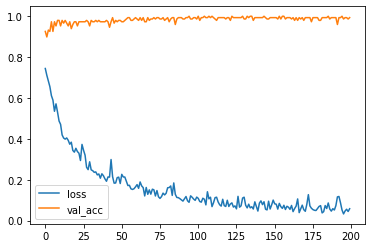

In [299]:

history = model.fit(x, y, epochs=200,validation_data=(x_test, y_test))
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_categorical_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [301]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])